In [3]:
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6.6 MB/s eta 0:00:000:00:0100:01


In [4]:
import pandas as pd
import numpy as np
import ast  
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import minmax_scale
from scipy.sparse import csr_matrix
from collections import defaultdict

2025-07-24 21:41:11.615519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753393271.844448      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753393271.910543      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Content Based

In [5]:
def content_recommend(title, df, sim_matrix, top_n=10):

    idx = df[df['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        print("Movie not found!")
        return 
        return pd.Series(dtype=float)

    idx = idx[0]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]

    # Normalize scores between 0 and 1
    # scores = minmax_scale(scores)

    movie_ids = df['id'].iloc[indices]
    return pd.Series(scores, index=movie_ids)



In [6]:
movie_final = pd.read_csv('/kaggle/input/tmdb12/movie_final3.csv')
similarity_matrix_mini_emb = np.load('/kaggle/input/tmdb12/MiniLMv6_movies_sim_matrix.npy')
similarity_matrix_tfidf = np.load('/kaggle/input/tmdb12/tfidf_movies_sim_matrix3.npy')

In [7]:
content_scores = content_recommend("8 mile", movie_final, similarity_matrix_tfidf)

In [8]:
# Print top recommended movie titles with scores
for movie_id, score in content_scores.items():
    title = movie_final.loc[movie_final['id'] == movie_id, 'title'].values[0]
    print(f"{title}: {score:.4f}")

Tupac: Resurrection: 0.3353
Hustle & Flow: 0.3330
You Got Served: 0.2719
Dance Flick: 0.2360
Brown Sugar: 0.2294
Boyz n the Hood: 0.2224
Dave Chappelle's Block Party: 0.2105
Burn: 0.2014
B-Girl: 0.1984
Begin Again: 0.1902


# Collaborative

In [9]:
def collaborative_recommend(user_id, user_embeddings_df, user_item_matrix, k=20, top_n=10):

    # Ensure user exists
    if user_id not in user_embeddings_df.index:
        raise ValueError(f"User ID {user_id} not found in user embeddings.")

    # Get embedding of the target user
    target_embedding = user_embeddings_df.loc[user_id].values.reshape(1, -1)

    # Compute cosine similarity with all users
    similarities = cosine_similarity(target_embedding, user_embeddings_df.values).flatten()
    similarity_series = pd.Series(similarities, index=user_embeddings_df.index)

    # Drop the user itself
    similarity_series.drop(user_id, inplace=True)

    # Get top-k similar users
    top_k_users = similarity_series.nlargest(k)
    similar_users_ratings = user_item_matrix.loc[top_k_users.index] / 5

    # print(similar_users_ratings.iloc[0])
    # Weighted average of ratings
    similarity_scores = top_k_users.values
    weighted_ratings = similar_users_ratings.T.dot(similarity_scores)


    # Mask of rated items (True where item is rated)
    rated_mask = ~similar_users_ratings.isna()
    
    # For each item (column), sum only the similarities of users who rated it
    sum_similarities = rated_mask.T.dot(similarity_scores)
    
    # Avoid divide-by-zero
    sum_similarities = np.where(sum_similarities == 0, 1e-9, sum_similarities)

    # print(sum_similarities)
    
    # Final recommendation scores
    recommendation_scores = weighted_ratings / sum_similarities
    recommendations = pd.Series(recommendation_scores, index=similar_users_ratings.columns)

    # Remove already-rated movies by the user
    already_rated = user_item_matrix.loc[user_id].dropna().index
    recommendations = recommendations.drop(already_rated, errors='ignore')

    # Drop NaNs or negative/zero scores
    recommendations = recommendations[recommendations.notna()]
    recommendations = recommendations[recommendations > 0]

    # Get top-N and normalize to 0–1 scale
    recommendations = recommendations.sort_values(ascending=False).head(top_n)

    return recommendations


In [10]:
user_embeddings_df = pd.read_parquet('/kaggle/input/tmdb12/user_embeddings2.parquet')
user_item_matrix = pd.read_parquet('/kaggle/input/tmdb12/user_item_matrix2.parquet')

In [11]:
user_id = 28  # any existing user ID
top_recs = collaborative_recommend(user_id, user_embeddings_df, user_item_matrix, k=20, top_n=10)

print("Top recommendations (tmdbIds):")
print(top_recs)

top_recs = top_recs.to_frame('score').reset_index().rename(columns={'tmdbId': 'id'})
top_recs = top_recs.merge(movie_final[['id', 'title']], on='id', how='left')
print(top_recs[['title', 'score']])

Top recommendations (tmdbIds):
tmdbId
389.0      0.865095
539.0      0.864938
694.0      0.859485
703.0      0.825683
1091.0     0.825409
1213.0     0.765453
10223.0    0.764897
409.0      0.715882
755.0      0.690281
163.0      0.635296
dtype: float64
                     title     score
0             12 Angry Men  0.865095
1                   Psycho  0.864938
2              The Shining  0.859485
3               Annie Hall  0.825683
4                The Thing  0.825409
5  The Talented Mr. Ripley  0.765453
6            A Simple Plan  0.764897
7      The English Patient  0.715882
8      From Dusk Till Dawn  0.690281
9           Ocean's Twelve  0.635296


# Hybrid (content + collaborative)

In [34]:
def hybrid_recommend(user_id, movie_df, user_item_matrix, user_embeddings_df, 
                     sim_matrix, content_weight=0.5, collab_weight=0.5, 
                     k=20, top_n=10):
    
    #Get high-rated movies by the user
    if user_id not in user_item_matrix.index:
        raise ValueError(f"User {user_id} not found in user-item matrix.")
    
    user_ratings = user_item_matrix.loc[user_id].dropna()
    high_rated = user_ratings[user_ratings >= 4].index

    if len(high_rated) == 0:
        print("No high-rated movies by user; fallback to collaborative only.")
        return collaborative_recommend(user_id, user_embeddings_df, user_item_matrix, k, top_n)

    #Aggregate content recommendations from all high-rated titles
    content_scores = {}
    for movie_id in high_rated:
        title_row = movie_df[movie_df['id'] == movie_id]
        if not title_row.empty:
            title = title_row.iloc[0]['title']
            scores = content_recommend(title, movie_df, sim_matrix, top_n=3)  # more than top_n for better merge
            for idx, score in scores.items():
                if idx in content_scores:
                    content_scores[idx] += score  #Sum scores
                else:
                    content_scores[idx] = score
                    

    #Convert to Series and normalize
    content_scores = pd.Series(content_scores)
    content_scores = content_scores.groupby(content_scores.index).mean()  #Average scores
    content_scores = content_scores[~content_scores.index.isin(user_ratings.index)]  #Remove already rated
    content_scores = content_scores[content_scores > 0]
    # content_scores = pd.Series(minmax_scale(content_scores), index=content_scores.index)

    print(content_scores)
    print(content_scores.describe())


    #Get collaborative recommendations
    collab_scores = collaborative_recommend(user_id, user_embeddings_df, user_item_matrix, k=k, top_n=50)
    # print(collab_scores.describe())
    
    #Use union instead of intersection
    all_movie_ids = content_scores.index.union(collab_scores.index)

    #Align both scores to full index and fill missing values with 0
    content_scores_aligned = content_scores.reindex(all_movie_ids, fill_value=0)
    collab_scores_aligned = collab_scores.reindex(all_movie_ids, fill_value=0)

    #Combine scores
    hybrid_scores = (
        content_weight * content_scores_aligned +
        collab_weight * collab_scores_aligned
    )

    #Sort and get top_n
    hybrid_scores = hybrid_scores.sort_values(ascending=False).head(top_n)

    #Add titles
    result = hybrid_scores.to_frame('score').reset_index().rename(columns={'index': 'id'})
    result = result.merge(movie_df[['id', 'title']], on='id', how='left')

    return result[['id', 'title', 'score']]


In [35]:
user_id = 28  # or any valid user ID

#Get recommendations
recommendations = hybrid_recommend(
    user_id=user_id,
    movie_df=movie_final,
    user_item_matrix=user_item_matrix,
    user_embeddings_df=user_embeddings_df,
    sim_matrix=similarity_matrix_tfidf ,
    content_weight=0.5,   # optional, default is 0.5
    collab_weight=0.5,    # optional, default is 0.5
    k=30,                 # number of similar users to consider
    top_n=10              # number of recommendations to return
)

print(recommendations)


118       0.628804
163       0.294525
173       0.471918
189       0.426000
203       0.208139
            ...   
385383    0.120609
385636    0.151281
385736    0.161664
426067    0.316063
433715    0.170647
Length: 1037, dtype: float64
count    1037.000000
mean        0.290322
std         0.183184
min         0.119174
25%         0.174617
50%         0.216962
75%         0.352393
max         1.875137
dtype: float64
         id                        title     score
0   72431.0                    Red Tails  0.937568
1   25784.0        Journey from the Fall  0.873787
2   11260.0                    Meet Dave  0.647292
3     440.0  Aliens vs Predator: Requiem  0.600585
4   50357.0                    Apollo 18  0.600224
5     539.0                       Psycho  0.591158
6   13889.0                     Madadayo  0.586234
7  281230.0                   Fort McCoy  0.536177
8  254904.0             The November Man  0.497916
9  227306.0                     Unbroken  0.473958


In [20]:
from tqdm import tqdm  # for a nice progress bar

# Reset score lists
all_content_scores = []
all_collab_scores = []

user_ids = np.random.choice(user_item_matrix.index, size=200, replace=False)

for uid in tqdm(user_ids):
    try:
        user_ratings = user_item_matrix.loc[uid].dropna()
        high_rated = user_ratings[user_ratings >= 4].index
        if len(high_rated) == 0:
            continue

        # --- Content-based recommendations ---
        content_scores = {}
        for movie_id in high_rated:
            title_row = movie_final[movie_final['id'] == movie_id]
            if not title_row.empty:
                title = title_row.iloc[0]['title']
                scores = content_recommend(title, movie_final, similarity_matrix_tfidf, top_n=3)
                for idx, score in scores.items():
                    content_scores[idx] = content_scores.get(idx, 0) + score

        if not content_scores:
            continue

        content_scores = pd.Series(content_scores)
        content_scores = content_scores.groupby(content_scores.index).mean()
        content_scores = content_scores[~content_scores.index.isin(user_ratings.index)]
        content_scores = content_scores[content_scores > 0]

        if content_scores.empty:
            continue

        content_scores = pd.Series(minmax_scale(content_scores), index=content_scores.index)

        # --- Collaborative recommendations ---
        collab_scores = collaborative_recommend(uid, user_embeddings_df, user_item_matrix, k=20, top_n=50)

        if collab_scores is None or len(collab_scores) == 0:
            continue

        collab_scores = pd.Series(minmax_scale(collab_scores), index=collab_scores.index)

        if content_scores.empty or collab_scores.empty:
            continue

        all_content_scores.extend(content_scores.values)
        all_collab_scores.extend(collab_scores.values)

    except Exception as e:
        print(f"User {uid} failed due to error: {e}")
        continue


100%|██████████| 200/200 [05:56<00:00,  1.78s/it]


In [21]:
print("Final collected:")
print("Content:", len(all_content_scores))
print("Collab:", len(all_collab_scores))

Final collected:
Content: 60584
Collab: 1071


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


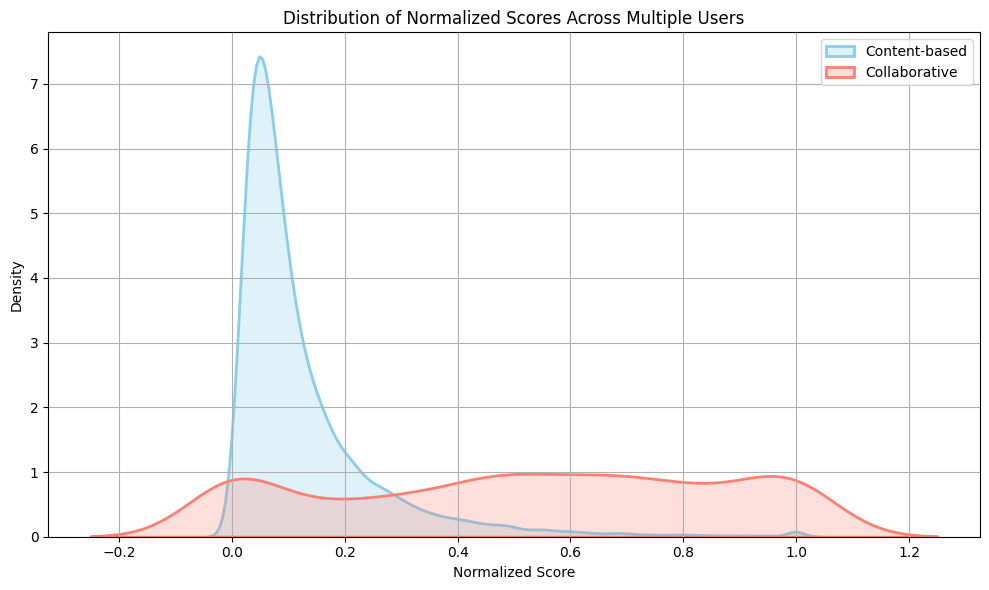

In [22]:
plt.figure(figsize=(10, 6))
sns.kdeplot(all_content_scores, label='Content-based', fill=True, color='skyblue', linewidth=2)
sns.kdeplot(all_collab_scores, label='Collaborative', fill=True, color='salmon', linewidth=2)
plt.title("Distribution of Normalized Scores Across Multiple Users")
plt.xlabel("Normalized Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
print("Raw content-based scores example:", content_scores.head())
print("Raw collaborative scores example:", collab_scores.head())


Raw content-based scores example: 79     0.057297
169    0.211126
173    0.279098
189    0.293953
200    0.694968
dtype: float64
Raw collaborative scores example: tmdbId
18785.0    0.0
dtype: float64
